Procedure for smearing
---------------------------------
There are two things you have to account for : muon-> neutrino scattering angle and error in reconstruction of muon direction.

The first  quantity is given in the variables PSF_min[deg]  PSF_max[deg] and the second in AngErr_min[deg]  AngErr_max[deg] in the files

1. For each neutrino energy and declination choose the average of PSF_min and PSF_max as well as average of AngErr_min[deg]  AngErr_max[deg]  and add them in quadrature. 
        This will give you the total angular uncertainty. ($\theta_{tot}$)

- For each simulated neutrino, take average of PSF_min and PSF_max as well as average of AngErr_min[deg]  AngErr_max[deg] and calculate $\sqrt{PSF_{avg}^2 + AngErr_{avg}^2}$

2. convert the simulated RA and DEC to theta  ($\theta_{mock}$) and phi  ($\phi_{mock}$) for the simulated MJD 

- Choose simulated MJD  to be uniformly distributed for each phase

3. assume error in theta=error in phi =($\theta_{tot}$)/$\sqrt(2)$

then choose Gausian distributed random numbers with **mean=0** and standard deviation = error in theta as well as error in phi.

This will give you the error in theta  ($\Delta \theta_{mock}$) and error in phi  ($\Delta \phi_{mock}$) for the simulated neutrino event

New theta=$\theta_{mock}$+$\Delta \theta_{mock}$

and New phi=$\phi_{mock}$+$\Delta \phi_{mock}$

4. Calculate new RA and DEC from new theta and new phi . This will be the smeared RA and DEC of the muon

5. as a sanity check calculate the angle between the smeared muon and the original pulsar direction. It should be close to $\theta_{tot}$.

Again all this should be in a separate code and decoupled from the routine to 
do the search.





 





In [1]:
from astropy.units import deg, meter
from astropy.coordinates import ICRS, get_sun, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
####syn_nu_ze
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
import pandas as pd

In [2]:
os.system("cp -r ./o_data/icecube_10year_ps/events/ ./data/icecube_10year_ps/events/")

from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
print(icwidths)


read icdata
read uptdata
read eadata
read mspdata
[36900, 107011, 93133, 136244, 112855, 122539, 127040, 129307, 123654, 145748]


In [3]:
latitude = -89.99
longitude = 13.2536#-63.453056
location = EarthLocation(lat=latitude * deg, lon=longitude * deg, height = 2835*meter)

def ra_dec_to_azimuth_zenith(ra_deg, dec_deg, obs_mjd):
    
    # Convert MJD to Time object
    obs_time = Time(obs_mjd, format='mjd')

    # Create a SkyCoord object with the given RA and Dec
    coord = SkyCoord(ra=ra_deg * deg, dec=dec_deg* deg, frame='icrs')

    # Convert to Altitude and Azimuth coordinates
    altaz = coord.transform_to(AltAz(location=location ,obstime=obs_time))

    # Calculate zenith angle (90° - altitude)
    # zenith_angle_deg = 90.0 - altaz.alt.deg
    alt_angle_deg = altaz.alt.deg

    # Extract Azimuth and Zenith Angle values (in degrees)
    azimuth_deg = altaz.az.deg
    
    return (azimuth_deg, alt_angle_deg)


def altaz_to_radec(azimuth, alt, mjd):
    
    # Convert zenith angle to altitude
    # altitude = (90 - zenith) * deg
    altitude = alt * deg
    
    # Convert MJD to Time object
    observing_time = Time(mjd, format='mjd', scale='utc')
    
    # Create EarthLocation
    
    # Create AltAz coordinate
    altaz = AltAz(location=location, obstime=observing_time)
    
    # Create SkyCoord from AltAz
    altaz_coord = SkyCoord(alt=altitude, az=azimuth, frame=altaz, unit=(deg, deg))
    
    # Convert AltAz coordinates to RA and Dec
    equatorial_coord = altaz_coord.transform_to('icrs')
    
    
    ra_deg = equatorial_coord.ra.deg
    dec_deg = equatorial_coord.dec.deg
    
    return (ra_deg, dec_deg)





In [16]:
icsmear_k = pd.read_csv('./data/icecube_10year_ps/irfs/IC40_smearing.csv', sep='\s+', comment='#', names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)

In [35]:
icsmear_k_log_E = np.array(list(set(icsmear_k['log10(E_nu/GeV)_min'])))#.union(set(icsmear_k['log10(E_nu/GeV)_max']))))
log_E_width = 26400
icsmear_k_log_E.sort()

# icsmear_k_log_E = 10**(icsmear_k_log_E+9)

# icsmear_k_dec = np.array(list(set(icsmear_k['Dec_nu_min[deg]']).union(set(icsmear_k['Dec_nu_max[deg]']))))
icsmear_k_dec = np.ravel(list(set(icsmear_k['Dec_nu_min[deg]'])))
icsmear_k_psf = np.array(list(set(icsmear_k['PSF_min[deg]']).union(set(icsmear_k['PSF_max[deg]']))))

icsmear_k_dec.sort()
dec_width = 123200

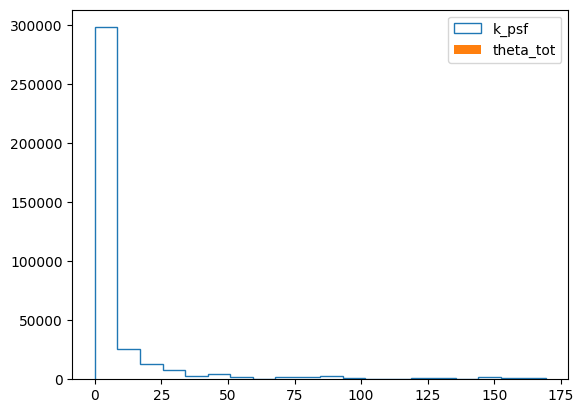

In [36]:
plt.hist(icsmear_k_psf, 20, histtype=  'step', label='k_psf')
plt.hist(adad, 20,label='theta_tot')
plt.legend()

In [9]:
season = 0
nbins=100
# if arrg.numbins:
#     nbins = arrg.numbins
# else:
#     nbins = 100

n_psrs = 30
# if arrg.numpulsars:
#     n_psrs = arrg.numpulsars

enus = np.logspace(11.001, 18.999, int(nbins))
# enus_bin_indices = np.zeros(len(enus), dtype=np.int64)

# for i in prange(len(enus)):
enus_bin_indices = np.digitize(enus, e_nu_wall) - 1


# msdec_bin_indices = np.zeros(p, dtype=np.int64)
# for i in prange(p):
msdec_bin_indices = np.digitize(msdec, dec_nu) - 1


gamma_arr = [-2, -2.2, -2.53, -3]
# phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

####
syn_nu_choice = np.random.randint(0, p, n_psrs) #Choose 50 random pulsars from the 3389 pulsars
syn_nudec_bin = msdec_bin_indices[syn_nu_choice] #Find the declination bin of the chosen pulsars to be allocated for the synthetic neutrinos
syn_nu_ra = msra[syn_nu_choice] #Find the right ascension of the chosen pulsars to be allocated for the synthetic neutrinos
syn_nu_dec = msdec[syn_nu_choice] #Find the declination of the chosen pulsars to be allocated for the synthetic neutrinos
phio_const = 4.98 * (10**(-27)) #GeV-1 to ev-1 conversion factor
# phio_const *= 1e-3
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
        "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]

# syn_nu_dec = []
syn_N_nu = 0   # No.of neutrinos generated per season per energy bin per declination bin
o_lengths = []







def get_syn_nu_dec(season_i):


    icdata_k = pd.read_csv("./o_data/icecube_10year_ps/events/" + filenames[season_i], sep="\s+", comment="#", names="MJD[days]	log10(E/GeV)	AngErr[deg]	RA[deg]	Dec[deg]	Azimuth[deg]	Zenith[deg]".split("\t"), dtype=float)
    o_lengths.append(len(icdata_k.index))

    uptdata_k = pd.read_csv("./o_data/icecube_10year_ps/uptime/" + filenames[season_i], sep="\s+", comment="#", names=["MJD_start[days]","MJD_stop[days]"], dtype=float, index_col=False)
    
    max_stop = max(uptdata_k["MJD_stop[days]"].values)
    min_start = min(uptdata_k["MJD_start[days]"].values)
    # uptdata_k = []
    icsmear_k = []
    try:
        icsmear_k = pd.read_csv("./o_data/icecube_10year_ps/irfs/" + filenames[season_i].replace('exp', 'smearing'), sep="\s+", comment="#", names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)
    except:
        icsmear_k = pd.read_csv("./o_data/icecube_10year_ps/irfs/" + filenames[4].replace('exp', 'smearing'), sep="\s+", comment="#", names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)
        # print(temp1)
    enus_smear_bin_min = icsmear_k_log_E[ np.digitize(np.log10(enus/1e9), icsmear_k_log_E) - 1]
    nu_smear_dec_bin_min = icsmear_k_dec[ np.digitize(syn_nu_dec, icsmear_k_dec) - 1]
    
    
    asdasd = []
    dsadsa = []
    for i in tqdm(range(len(enus))):    
        # print(i, enus_smear_bin_min[i])
        temp1 = icsmear_k[icsmear_k["log10(E_nu/GeV)_min"] == enus_smear_bin_min[i]]
        # print(icsmear_k["log10(E_nu/GeV)_min"].value_counts())
        for j in range(len(syn_nu_dec)):
        
            temp2 = temp1[temp1["Dec_nu_min[deg]"] == nu_smear_dec_bin_min[j]]        
            # print(len(temp2))
        
            try:
                psf_avg = (min(temp2["PSF_min[deg]"]) + max(temp2["PSF_max[deg]"])) / 2
            except:
                print(np.log10(enus_smear_bin_min[i]-9), nu_smear_dec_bin_min[j])
                print(temp1)
       
            angerr_avg = (min(temp2["AngErr_min[deg]"]) + max(temp2["AngErr_max[deg]"])) / 2
            theta_tot = np.sqrt(psf_avg**2 + angerr_avg**2)
            dsadsa.append(theta_tot)
            # No.of neutrinos to be generated in this season, in this energy bin, in this declination bin
            n_nu_temp = t_upt[season_i] * earea[ea_season(season_i)][syn_nudec_bin[j] * 40 + enus_bin_indices[i]] * enus[i] * phio_const * ((enus[i] / 10**14) ** gamma_arr[2])
            # print(n_nu_temp, i, j)
            n_nu_temp = int(n_nu_temp)
            if n_nu_temp > 0:
                mjd = np.random.uniform(min_start, max_stop, n_nu_temp)
                temp_ra = np.ones(n_nu_temp, dtype=np.float64) * syn_nu_ra[j]
                temp_dec = np.ones(n_nu_temp, dtype=np.float64) * syn_nu_dec[j]
                
                
                # print(type(temp_ra), type(temp_dec), type(mjd))
                # print(temp_ra.shape, temp_dec.shape, mjd.shape)
                syn_nu_az, syn_nu_alt = ra_dec_to_azimuth_zenith(temp_ra, temp_dec, mjd)
                
                errs = np.random.normal(0, theta_tot/(2**0.5), n_nu_temp)
                
                syn_nu_az += errs
                syn_nu_alt += errs
                
                for xx in prange(len(syn_nu_alt)):
                    if syn_nu_alt[xx] > 90:
                        syn_nu_alt[xx] = 180 - syn_nu_alt[xx]
                    
                    elif syn_nu_alt[xx] < -90:
                        syn_nu_alt[xx] = -180 - syn_nu_alt[xx]
                    else:
                        pass
                    
                
                
                syn_ra, syn_dec = [], []
                # for taz, tze, tmjd in enumerate(zip(syn_nu_az, syn_nu_ze, mjd)):
                #     tra, tdec = altaz_to_radec(taz, tze, tmjd)
                #     syn_ra.append(tra)
                #     syn_dec.append(tdec)
                for temp_i in range(len(syn_nu_az)):
                    tra, tdec = altaz_to_radec(syn_nu_az[temp_i], syn_nu_alt[temp_i], mjd[temp_i])
                    syn_ra.append(tra)
                    syn_dec.append(tdec)
                    
                syn_ra = np.array(syn_ra)
                syn_dec = np.array(syn_dec)
                # print(np.median(hvovec(msra[syn_nu_choice[j]], msdec[syn_nu_choice[j]], syn_ra, syn_dec)))
                asdasd.append(max(hvovec(msra[syn_nu_choice[j]], msdec[syn_nu_choice[j]], syn_ra, syn_dec)))
                # syn_ra, syn_dec = altaz_to_radec(syn_nu_az, syn_nu_ze, mjd)
                
                # print(type(syn_nu_ze), type(syn_nu_az))
                
                temp3 = pd.DataFrame(np.vstack([mjd, -1 * np.ones(len(mjd)), errs, syn_ra, syn_dec, syn_nu_az, syn_nu_alt]).T)
                
                icdata_k = pd.concat([icdata_k, temp3], ignore_index=True)
                
                
            else:
                continue
    # icdata_k.to_csv("./data/icecube_10year_ps/irfs/" + filenames[season_i], sep="\t", index=False)
    print("Done with season", season_i)
    
    print(season_i, len(icdata_k.index))
    return asdasd, dsadsa
    
    

In [10]:
# pool = mul.Pool(12)
# op_async = pool.map_async(get_syn_nu_dec, tqdm(range(10)))
# drive = op_async.get()
# pool.close()
# pool.join()
# op_async = []
# print("Generated Synthetic neutrinos and added to original IceCube Data")

100%|██████████| 100/100 [00:40<00:00,  2.44it/s]

Done with season 0
0 45936


(array([256., 237.,  61.,  65.,  60.,  85.,  62.,  28.,  10.,   4.]),
 array([  0.20846275,  17.95340129,  35.69833982,  53.44327836,
         71.1882169 ,  88.93315544, 106.67809398, 124.42303251,
        142.16797105, 159.91290959, 177.65784813]),
 <BarContainer object of 10 artists>)

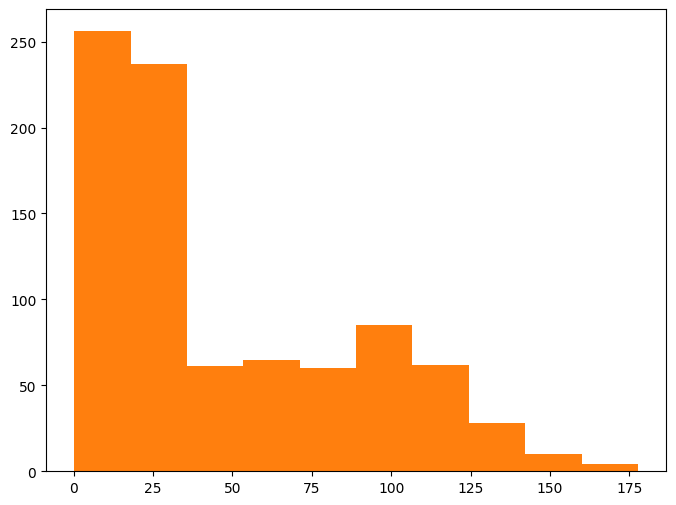

In [14]:
plt.figure(figsize=(8,6))
dada, adad = get_syn_nu_dec(0)

plt.hist(dada)
plt.hist(dada)

(array([713., 869., 117.,  54.,  54.,  66.,  54., 300., 403., 370.]),
 array([ 0.        ,  8.47081102, 16.94162204, 25.41243306, 33.88324408,
        42.35405509, 50.82486611, 59.29567713, 67.76648815, 76.23729917,
        84.70811019]),
 <BarContainer object of 10 artists>)

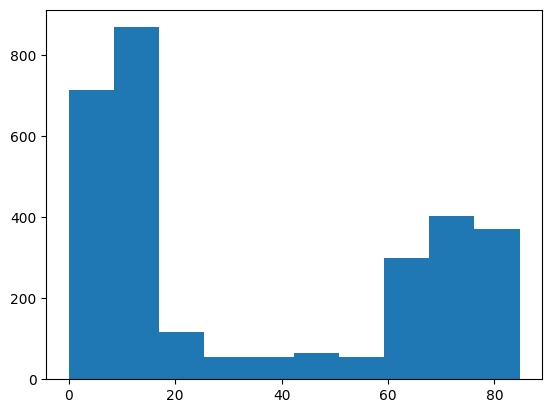

In [15]:
# plt.hist(dada)
plt.hist(adad)